# TD3

For ReLAx & Mujoco installation see:
https://github.com/nslyubaykin/relax/blob/master/README.md

Useful readings regarding TD3:
- TD3 paper: https://arxiv.org/abs/1802.09477
- TD3 description: https://spinningup.openai.com/en/latest/algorithms/td3.html

!Note: For examining trained actor you may just load trained policies from \trained_models directory.
To do that instead of running 'Run Training and Validation loop' cell, just run 'Load Models' cell

!Note: Trained policies, logs and videos are in the main repository of that notebook: https://github.com/nslyubaykin/relax_td3_example

In [12]:
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from inspect import getsource
from torch.utils.tensorboard import SummaryWriter

from relax.rl.actors import TD3
from relax.rl.critics import CDQN

from relax.zoo.policies import DeterministicMLP
from relax.zoo.critics import ContQMLP

from relax.schedules import PiecewiseSchedule, LinearSchedule, CombinedSchedule
from relax.exploration import RandomNormal

from relax.data.sampling import Sampler
from relax.data.replay_buffer import ReplayBuffer

from relax.gym.utils import visualize_actor

# Constructing Actor's deterministic policy

TD3 is a continuous control algorithm and its policy does not have any
stochasticity inside itself. So policy is just a neural network mapping observation space 
with a shape (BATCH_SIZE, *obs.shape) to a continuous action space (BATCH_SIZE, ACS_DIM).

Therefore any custom user defined networks meeting this requirements should work well 
with TD3 actor

Preferably action space should have some finite range of values, e.g [-1, 1].

So let's examine the default implementation of deterministic policy offered by ReLAx:

In [2]:
print(getsource(DeterministicMLP))

class DeterministicMLP(nn.Module):
    
    def __init__(self, obs_dim, acs_dim, 
                 hidden1=400, hidden2=300,
                 activation=nn.ReLU(),
                 out_activation=nn.Identity(),
                 acs_scale=1.0, acs_bias=0.0):
        
        super(DeterministicMLP, self).__init__()
        
        layers = []
        layers.append(nn.Linear(obs_dim, hidden1))
        layers.append(activation)
        layers.append(nn.Linear(hidden1, hidden2))
        layers.append(activation)
        layers.append(nn.Linear(hidden2, acs_dim))
        layers.append(out_activation)
        self.layers = nn.Sequential(*layers)
        self.acs_dim = acs_dim
        self.acs_scale = acs_scale
        self.acs_bias = acs_bias
        
    def forward(self, obs):
        flat_obs = torch.flatten(obs, start_dim=1)
        acs = self.layers(flat_obs)
        return acs * self.acs_scale + self.acs_bias



# Constructing Continuous Deep Q-Network Critic

Actor's deterministic policy is trained in pair with  2 critic networks which approximate Q-Function for a given observation-action pair. That means that critic net is taking as an input an observations batch with a shape of (BATCH_SIZE, *obs.shape) and a batch of corresponding actions with a shape (BATCH_SIZE, ACS_DIM) and outputting Q-Values batch with a shape (BATCH_SIZE, 1).

Therefore any custom user defined networks meeting this requirements should work well with CDQN critic

So let's examine the default implementation of Continuous Deep Q-Network Critic offered by ReLAx:

In [3]:
print(getsource(ContQMLP))

class ContQMLP(nn.Module):
    
    def __init__(self, obs_dim, acs_dim, 
                 hidden1=400, hidden2=300,
                 activation=nn.ReLU(),
                 out_activation=nn.Identity(),
                 init_w=3e-3):
        
        super(ContQMLP, self).__init__()
        
        self.fc1 = nn.Linear(obs_dim+acs_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, 1)
        self.activation = activation
        self.out_activation = out_activation
        self.acs_dim = acs_dim
        
    def forward(self, obs, acs):
        
        out = self.fc1(
            torch.cat(
                [torch.flatten(obs, start_dim=1), acs], 
                dim=-1
            )
        )
        out = self.activation(out)
        out = self.fc2(out)
        out = self.activation(out)
        out = self.fc3(out)
        out = self.out_activation(out)
        
        return out



# Define Schedules for Training:

Our TD3 actor will not learn for the first 10k iterations. (Told to actor by passing 0 learning rate for the first 10k iterations)

And it will also conduct maximum exploration during that phase to collect initial random training data. 

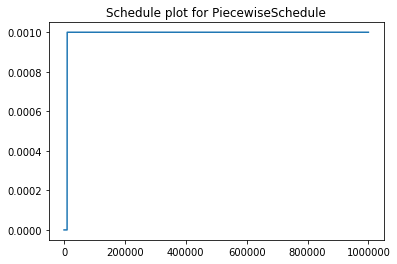

In [4]:
# Creating schedules:
# first 10000 iterations no learning - just data collection
policy_lr = PiecewiseSchedule({0: 10000}, 1e-3)
critic_lr = PiecewiseSchedule({0: 10000}, 1e-3)
policy_lr.plot(int(1e6))

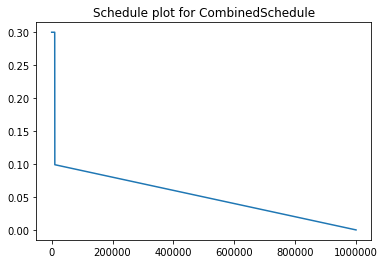

In [5]:
schedule1 = PiecewiseSchedule({0.3: 10000}, 0.0)
schedule2 = LinearSchedule(0.1, 0, 1000000)
sigma_schedule = CombinedSchedule(schedule1, schedule2, max)
sigma_schedule.plot(int(1e6))

# Create training and eval environments

In [6]:
env_name = 'Walker2d-v2'
env = gym.make(env_name)
eval_env = gym.make(env_name)
eval_env.seed(np.random.randint(100))

[68]

In [7]:
env.action_space, env.action_space.high, env.action_space.low

(Box(6,),
 array([1., 1., 1., 1., 1., 1.], dtype=float32),
 array([-1., -1., -1., -1., -1., -1.], dtype=float32))

In [8]:
env.observation_space

Box(17,)

In [10]:
acs_dim = 6
obs_dim = 17

# Set Up Exploration

TD3 uses noise sampled from random normal distribution. In TD3 paper authors state that Ornstein-Uhlenbeck random noise and its temporal correlation does not bring any additional benefit comparing to simpler random normal noise according to their experiments. Noise then added to actor's deterministic actions in order to drive exploration. Noise magnitude is typically annealed over the course of training. In some sense the overall logic of altering actor's actions randomly resembles E-Greedy exploration for DQN.

In [13]:
exploration = RandomNormal(sigma=sigma_schedule,
                           min_acs=-1.0,
                           max_acs=1.0,
                           n_random_steps=10000)

# Define TD3 actor:


In [19]:
actor = TD3(
    device=torch.device('cuda'),
    mu_net=DeterministicMLP(obs_dim, acs_dim, out_activation=torch.nn.Tanh()),
    learning_rate=policy_lr,
    batch_size=100,
    min_acs=-1.0,
    max_acs=1.0,
    exploration=exploration,
)

# Define CDQN critic:

!Note: TD3 is using 2 critic networks instead of 1 in DDPG. That is done to reduce Q-value overestimation bias by taking the smaller of the two Q-values to form the targets in the Bellman error loss functions

In [20]:
critic = CDQN(
    critic_net=ContQMLP(obs_dim, acs_dim),
    critic_net2=ContQMLP(obs_dim, acs_dim),
    device=torch.device('cuda'),
    learning_rate=critic_lr,
    weight_decay=0.0
)

# Provide actor with critic:

!Note: Unlike A2C or PPO/TRPO + GAE architectures TD3 updates actor and critic on the same batch of data, so critic is updated implicitly inside actor's update() method. Still, CDQN critic has its own update() method which is created to step schedules and follow the general API

In [21]:
actor.set_critic(critic)

# Create replay buffer and wrap envs into Sampler:

In [22]:
sampler = Sampler(env=env)
eval_sampler = Sampler(env=eval_env)


replay_buffer = ReplayBuffer(int(1e+6))

# Visualize untrained actor

In [23]:
visualize_actor(env=eval_env, actor=actor, nsteps=1000, train_sampling=False)

Simulation done, total reward: 48.6305732402305
Loading video...


# Run Training and Validation loop:

In [ ]:
log_every = 10000
n_steps = 1000000
logdir = '/home/nikita/Desktop/RelaxExamples/TD3/tensorboard_logs'
run_name = 'td3_walker2d'
logger = SummaryWriter(log_dir=f'{logdir}/{run_name}')

for step in tqdm(range(n_steps)): # 
    
    # sample training batch
    unit_pathlist = sampler.sample(actor=actor,
                                   n_transitions=1,
                                   max_path_length=None, 
                                   reset_when_not_done=False,
                                   train_sampling=True)
    # policy.set_device(torch.device('cuda'))
    
    # add transitions to replay buffer
    replay_buffer.add_paths(unit_pathlist)
    
    # update critic
    critic_logs = critic.update(replay_buffer)
        
    # update actor
    actor_logs = actor.update(replay_buffer)
    
    if step % log_every == 0 and step > 0:
        
        # create logs of buffer
        buffer_logs = replay_buffer.create_logs(prefix='buffer')
        
        # evaluating the policy
        eval_batch = eval_sampler.sample_n_episodes(actor=actor,
                                                    n_episodes=5,
                                                    max_path_length=None, 
                                                    train_sampling=False)
        eval_logs = eval_batch.create_logs(prefix='eval')
        logs = {**critic_logs,
                **actor_logs,
                **buffer_logs,
                **eval_logs}
        
        for key, value in logs.items():
            logger.add_scalar(key, value, step)
    
logger.flush()

 45%|████▌     | 452052/1000000 [1:31:31<2:01:25, 75.22it/s] 

In [24]:
%load_ext tensorboard
%tensorboard --logdir /home/nikita/Desktop/RelaxExamples/TD3/tensorboard_logs

# Visualize trained actor

In [ ]:
visualize_actor(env=eval_env, actor=actor, nsteps=200, train_sampling=False)

# Save Models

In [ ]:
actor.save_checkpoint('trained_models', 'td3_actor')
critic.save_checkpoint('trained_models', 't3d_critic')

# Load Models

In [ ]:
policy.load_checkpoint('trained_models', 'td3_actor')
critic.load_checkpoint('trained_models', 't3d_critic')